# Introduction to Data Science
## Clustering
***

Read in some packages.

In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance

%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 14, 8

# I've abstracted some of what we'll be doing today into a library.
# You can take a look at this code if you want by going into `dstools/data_tools.py`
from dstools import data_tools

np.random.seed(36)

### Data
We have a data set describing many characteristics of scotch. You can find it in `data/scotch.csv`.

The data consists of 5 general whiskey attributes, each of which has many possible values:

- **Color**: yellow, very pale, pale, pale gold, gold, old gold, full gold, amber, etc.
- **Nose**: aromatic, peaty, sweet, light, fresh, dry, grassy, etc.
- **Body**: soft, medium, full, round, smooth, light, firm, oily.
- **Palate**: full, dry, sherry, big, fruity, grassy, smoky, salty, etc.
- **Finish**: full, dry, warm, light, smooth, clean, fruity, grassy, smoky, etc.

Let's read it in and take a look. There are a few other features unrelated to the ones above. For this class, we will be dropping them. However, feel free to check them out!

In [2]:
data = pd.read_csv("data/scotch.csv")
data = data.drop([u'age', u'dist', u'score', u'percent', u'region', u'district', u'islay', u'midland', u'spey', u'east', u'west', u'north ', u'lowland', u'campbell', u'islands'], axis=1)

In [3]:
data.head()

,color.wyne,color.yellow,color.v.pale,color.pale,color.p.gold,color.gold,color.o.gold,color.f.gold,color.bronze,color.p.amber,...,fin.smoke,fin.sweet,fin.spice,fin.oil,fin.salt,fin.arome,fin.ling,fin.long,fin.very,fin.quick
Aberfeldy,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Aberlour,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Ardberg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Ardmore,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Auchentoshan,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Similarity measures
Each of our whiskeys can be described by its feature vector (68 attributes). Consider Foster's favorite, "Bunnahabhain".

In [4]:
print data_tools.feature_printer(data, 'Bunnahabhain')

'color.gold', 'nose.fresh', 'nose.sea', 'body.med', 'body.light', 'body.firm', 'pal.clean', 'pal.fruit', 'pal.sweet', 'fin.full'


What other entries do we have that are similar?

In [5]:
# For a full list of the distance metrics supported by scipy, check:
# http://docs.scipy.org/doc/scipy/reference/spatial.distance.html

def whiskey_distance(name, distance_measures, n):
    # We want a data frame to store the output
    distances = pd.DataFrame()
    
    # Find the location of the whiskey we are looking for
    whiskey_location = np.where(data.index == name)[0][0]

    # Go through all distance measures we care about
    for distance_measure in distance_measures:
        # Find all pairwise distances
        current_distances = distance.squareform(distance.pdist(data, distance_measure))
        # Get the closest n for the whiskey we care about
        most_similar = np.argsort(current_distances[:, whiskey_location])[0:n]
        # Append results
        distances[distance_measure] = zip(data.index[most_similar], current_distances[most_similar, whiskey_location])
    return distances

In [6]:
whiskey_distance('Bunnahabhain', ['euclidean'], 6)

,euclidean
0,"(Bunnahabhain, 0.0)"
1,"(Glenglassaugh, 3.0)"
2,"(Ardberg, 3.16227766017)"
3,"(Bruichladdich, 3.16227766017)"
4,"(Tullibardine, 3.31662479036)"
5,"(Caperdonich, 3.46410161514)"


In [7]:
whiskey_distance('Bunnahabhain', ['euclidean', 'cityblock', 'cosine'], 6)

,euclidean,cityblock,cosine
0,"(Bunnahabhain, 0.0)","(Bunnahabhain, 0.0)","(Bunnahabhain, 0.0)"
1,"(Glenglassaugh, 3.0)","(Glenglassaugh, 9.0)","(Glenglassaugh, 0.472953723305)"
2,"(Ardberg, 3.16227766017)","(Ardberg, 10.0)","(Tullibardine, 0.473765188416)"
3,"(Bruichladdich, 3.16227766017)","(Bruichladdich, 10.0)","(Glenmorangie, 0.492907447163)"
4,"(Tullibardine, 3.31662479036)","(Tullibardine, 11.0)","(Bruichladdich, 0.5)"
5,"(Caperdonich, 3.46410161514)","(Caperdonich, 12.0)","(Ardberg, 0.5)"


We can take a look at the features some of these have and see why they are ranked as being most similar.

In [21]:
print data_tools.feature_printer(data, 'Bunnahabhain')

'color.gold', 'nose.fresh', 'nose.sea', 'body.med', 'body.light', 'body.firm', 'pal.clean', 'pal.fruit', 'pal.sweet', 'fin.full'


In [23]:
print data_tools.feature_printer(data, 'Bruichladdich')

'color.pale', 'nose.light', 'body.smooth', 'body.light', 'body.firm', 'pal.dry', 'pal.clean', 'pal.smoke', 'pal.sweet', 'fin.full'


In [22]:
print data_tools.feature_printer(data, 'Ardberg')

'color.sherry', 'nose.peat', 'nose.dry', 'nose.sea', 'body.med', 'body.full', 'body.light', 'body.firm', 'pal.sweet', 'fin.salt'


### Clustering
Can we find groups of whiskeys that are simliar?

#### Hierarchical

Given a set of records (A-F) with two features, we can visualize them on a 2 dimensional surface. Here, circles are drawn around groups of points that are the most "similar" to one another (closest together). These nested circles form a hierarchy.

<img src="images/cutting.png" height=40% width=40%>

Consider our whiskey data. Here we can visualize a part of this hierarchy in a dendrogram.

<img src="images/cross_section.png" height=70% width=70%>

Let's see what it looks like for all of our data.

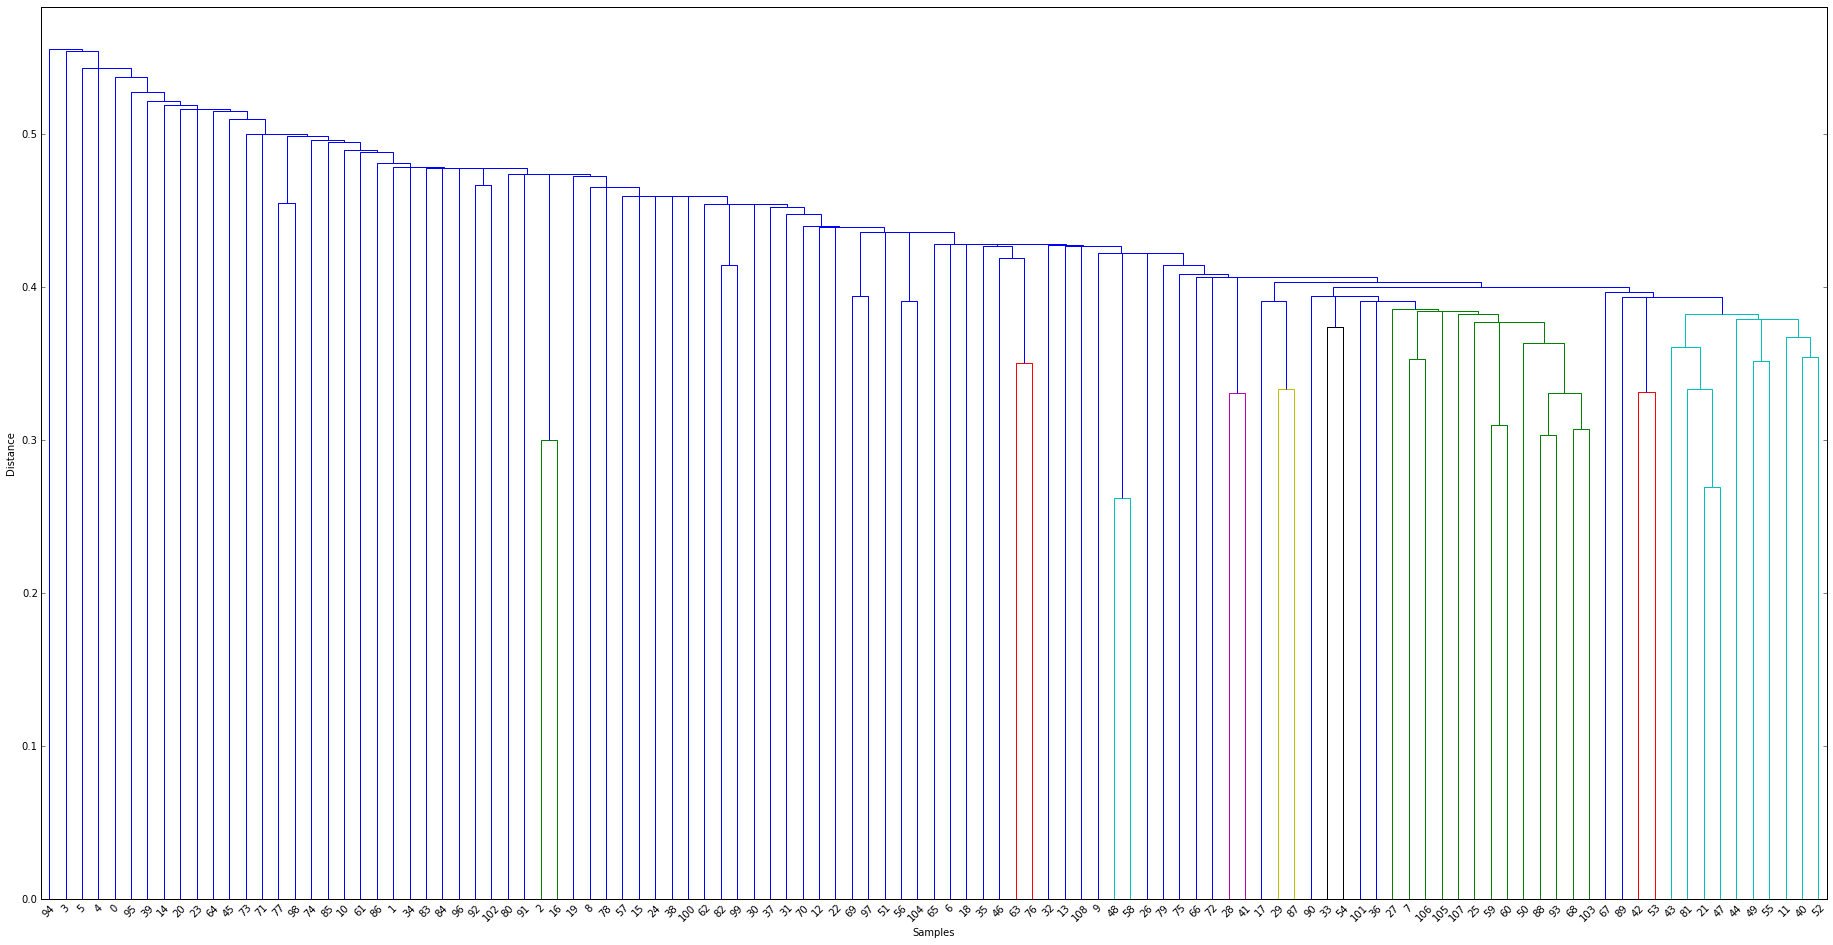

In [8]:
# This function gets pairwise distances between observations in n-dimensional space.
dists = pdist(data, metric="cosine")
# This function performs hierarchical/agglomerative clustering on the condensed distance matrix y.
links = linkage(dists)

p = 46
# Now we want to plot the dendrogram
plt.rcParams['figure.figsize'] = 32, 16
den = dendrogram(links)#, p = 20, truncate_mode="level")
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.xticks(rotation=45)
# plt.ylim([.5, .56])
plt.show()
plt.rcParams['figure.figsize'] = 10, 8

It is common to cut dendrograms at a particular height and to then use the resulting clusters. For example, here we have ten clusters labeled by the "best known" whiskey in the group.

<img src="images/clustering.png" height=90% width=90%>

#### KMeans

Another method for finding clusters is to use the KMeans algorithm to find a set of $k$ clusters. Here, unlike in hierarchical clustering, we define the number of clusters in advance.

In [9]:
k_clusters = 6

# Fit and predict clusters
model = KMeans(k_clusters)
model.fit(data)
clusters = model.predict(data)

# Do some messy stuff to print a nice table of clusters
cluster_listing = {}
for cluster in range(k_clusters):
    cluster_listing['Cluster ' + str(cluster)] = [''] * 109
    where_in_cluster = np.where(clusters == cluster)[0]
    cluster_listing['Cluster ' + str(cluster)][0:len(where_in_cluster)] = data.index[where_in_cluster]

# Print clusters
pd.DataFrame(cluster_listing).loc[0:np.max(np.bincount(clusters)) - 1,:]

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:797: RuntimeWarning: Got data type int64, converted to float to avoid overflows
  X = self._check_test_data(X)


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,Auchentoshan,Aberlour,Benriach,Ardmore,Aberfeldy,Ardberg
1,Aultmore,Balvenie,Bunnahabhain,Brackla,Balmenach,Benromach
2,Balblair,Benrinnes,Cragganmore,Convalmore,Banff,Bowmore
3,Ben Nevis,Clynelish,Edradour,Craigellachie,Caperdonich,Cardhu
4,Bladnoch,Dalmore,Glenallachie,Dailuaine,Dallas Dhu,Dufftown
5,Blair Athol,Glendullan,Glen Deveron,Dalwhinnie,Glencadam,Glen Albyn
6,Bruichladdich,Glenfarclas,Glenesk,Deanston,Glen Elgin,Glen Keith
7,Caol Ila,Glenrothes,Glengoyne,Glendronach,Glen Garioch,Glenlochy
8,Coleburn,Glen Scotia,Glenkinchie,Glen Grant,Glen Ordie,Glenury Royal
9,Fettercairn,Glenugie,Glenlossie,Glen Mhor,Glenturret,Jura


How do we name or describe these clusters? There are a few common approaches:

1. Simply list the items in the cluster and use these names as the description
2. Choose the best of its class (requires some domain knowledge)
3. Present the average of the features inside of each cluster
4. Create a model

To expand on option (4), let's take a look at the results of a particular clustering from Lapointe and Legendre's *A Classification of Pure Malt Scotch Whiskies*. In this clustering, they create 12 clusters A through L. Let's take cluster J as an example and built a decision tree that will classifier all whiskies as either belonging to J or not belonging to J.

<img src="images/cluster_tree.png" height=50% width=50%>

Let's take a look at a different data set that only has two features. This will make visualizing the data much easier.

In [10]:
X, Y = data_tools.make_cluster_data()

We can plot the data and take a look.

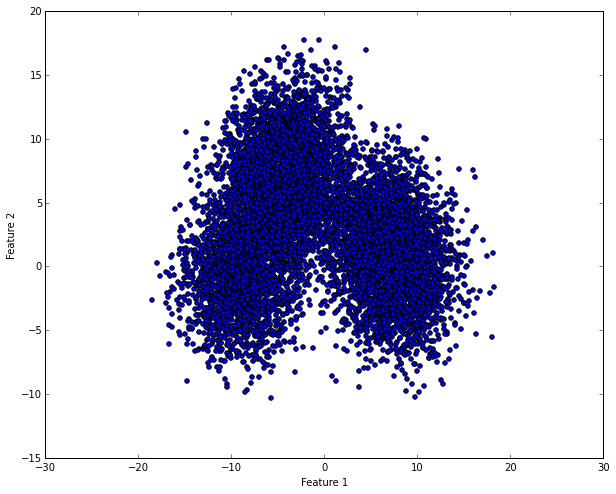

In [11]:
plt.scatter(X[:,0], X[:, 1], s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Similar to what we did above, we can apply KMeans to this data. Let's try a few different values for the number of clusters $k$.

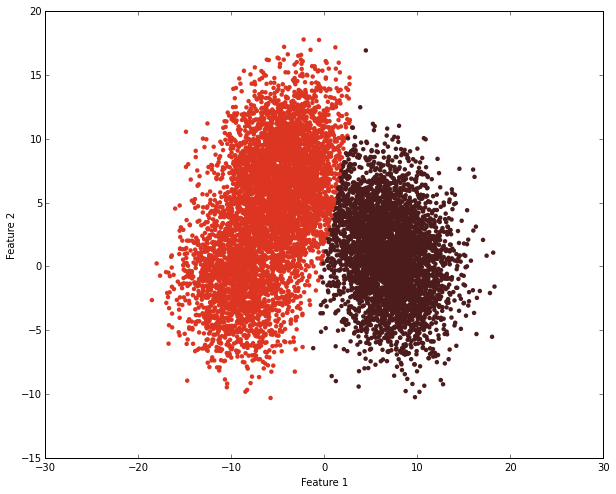

In [12]:
# KMeans
model = KMeans(2)
model.fit(X)
clusters = model.predict(X)
plt.scatter(X[:,0], X[:, 1], color=data_tools.colorizer(clusters), linewidth=0, s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Classification

What if we have labels for our records? In this 2 dimensional data that we're using, we have five numerical labels, 0 through 4. One way to use clustering to build a classifier is to use the K-Nearest Neighbors algorithm.

We'll start by splitting our X and Y data into train and test sets.

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

Now, let's try setting the number of neighbors to use, $k$, to a few different values and look at the results.

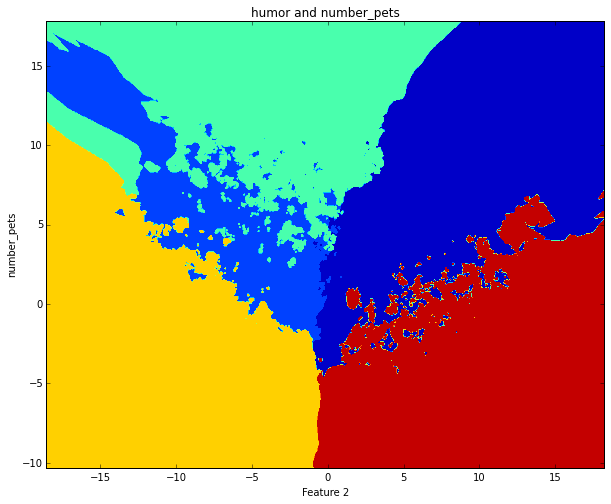

In [17]:
# KNN
model = KNeighborsClassifier(10)
model.fit(X_train, Y_train)
data_tools.Decision_Surface(X, Y, model, cell_size=.05, surface=True, points=False)

You can see that as we make $k$ smaller, we get many smaller blobs all bunched together. What happens when we get down to $k=1$?

Even though we have 5 classes, we can still use the evaluation metrics we have already learned about. Accuracy should be straight forward:

In [18]:
model = KNeighborsClassifier(10)
model.fit(X_train, Y_train)
metrics.accuracy_score(Y_test, model.predict(X_test))

0.70799999999999996

With a few small tweaks, we can also look at AUC:

In [19]:
for k in [10]:
    model = KNeighborsClassifier(k)
    model.fit(X_train, Y_train)
    probabilities = model.predict_proba(X_test)

    print "KNN with k = %d" % k
    aucs = 0
    for i in range(5):
        auc = metrics.roc_auc_score(Y_test == i, probabilities[:,i])
        aucs += auc
        print "   AUC for label %d vs. rest = %.3f" % (i, auc)
    print "   Average AUC = %.3f\n" % (aucs / 5.0)

KNN with k = 10
   AUC for label 0 vs. rest = 0.926
   AUC for label 1 vs. rest = 0.868
   AUC for label 2 vs. rest = 0.920
   AUC for label 3 vs. rest = 0.977
   AUC for label 4 vs. rest = 0.940
   Average AUC = 0.926

